In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
import nbformat
from Data_preparation import train_test_split_for_data_autoencoder
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential




## Functions to work with

In [2]:
def autoencoder_train(x_train, latent_dim:int, divider:int):
    input_dim = x_train.shape[1] 
    autoencoder = Sequential()
    
    autoencoder.add(Dense(input_dim, activation='relu', input_shape = (input_dim,)))
    autoencoder.add(Dense(int(input_dim/divider), activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(latent_dim, activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(int(input_dim/divider), activation='relu', kernel_initializer='he_uniform'))
    autoencoder.add(Dense(input_dim, activation='relu', kernel_initializer='he_uniform'))
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    autoencoder.compile(loss='mean_squared_error', optimizer=custom_optimizer)
    autoencoder.summary()

    history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_split=0.2)
    return autoencoder, history

In [3]:
def autoencoder_evaluate(model, x_test, y_test, difference_calculating_function, threshold_of_difference, with_cm):
    predictions = model.predict(x_test)
    real_count_vectors = x_test.to_numpy()
    difference_vector = difference_calculating_function(predictions, real_count_vectors)
    y_pred =  (difference_vector > threshold_of_difference).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    if with_cm:
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix")
        plt.show()
        print(cm)
    precision = (cm[1,1]) / (cm[1,1] + cm[0,1])
    recall = (cm[1,1]) / (cm[1,1] + cm[1,0])
    f_score = 2*precision*recall / (precision+recall)
    accuracy = (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
    true_positive_rate = cm[1,1] / (cm[1,0] + cm[1,1])
    false_positive_rate = cm[0,1] / (cm[0,1] + cm[0,0])

    return precision, recall, f_score, accuracy, true_positive_rate, false_positive_rate

In [4]:
def difference_calculating_function_cosine_dissimilarity(predictions, real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    
    #Loop through each pair of corresponding vectors
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]
            
        dot_product = np.dot(vector_a, vector_b)
        norm_a = np.linalg.norm(vector_a)
        norm_b = np.linalg.norm(vector_b)
            
        cosine_similarity = dot_product / (norm_a * norm_b)
        difference_vector[i] = 1 - cosine_similarity
        
    return difference_vector

In [5]:
def difference_calculating_function_l_norm(predictions,  real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]

        difference_vector[i] = np.linalg.norm(vector_a-vector_b, ord = 1)
    return difference_vector

In [6]:
def plot_history(history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
def create_f_score_recall_precision_plots(model, x_test, y_test, difference_calculating_function, thresholds, title):
    f_scores_list = []
    recalls_list = []
    precisions_list = []
    accuracy_list = []
    TPR = []
    FPR = []
    for threshold in thresholds:
        precision, recall, f_score, accuracy, true_positive_rate, false_positive_rate = autoencoder_evaluate(model, x_test, y_test, difference_calculating_function, threshold, False)
        f_scores_list.append(f_score)
        recalls_list.append(recall)
        precisions_list.append(precision)
        accuracy_list.append(accuracy)
        TPR.append(true_positive_rate)
        FPR.append(false_positive_rate)
    plt.plot(thresholds, f_scores_list, label = 'F-score')
    plt.plot(thresholds, precisions_list, label = 'Precision')
    plt.plot(thresholds, recalls_list, label = 'Recalls')
    plt.plot(thresholds, accuracy_list, label = 'Accuracy')
    plt.xlabel('Thresholds')
    plt.ylabel('Score value')
    plt.legend()
    plt.title(title)
    plt.show()
    plt.plot(FPR, TPR)
    plt.title('ROC-curve ' + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')


## Fully unsupervised learning

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,100 (16.02 KB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.4654 - val_loss: 0.7702
Epoch 2/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6462 - val_loss: 0.7664
Epoch 3/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6576 - val_loss: 0.7363
Epoch 4/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6497 - val_loss: 0.3964
Epoch 5/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3334 - val_loss: 0.3957
Epoch 6/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3062 - val_loss: 0.3946
Epoch 7/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3006 - val_loss: 0.3868
Epoch 8/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2979 - val_loss: 0.3247
Epoch 9/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2133 - val_loss: 0.2935
Epoch 10/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1798 - val_loss: 0.2813
Epoch 11/100
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1831 - val_loss: 0.2418
Epoch 12/100
2876

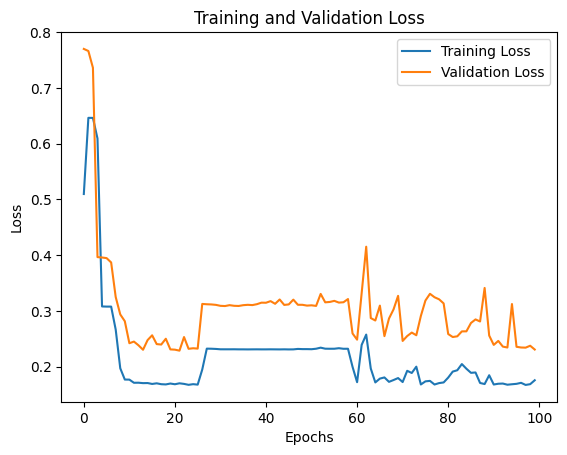

In [8]:
x_train, y_train, x_test, y_test = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, False)
autoencoder_model, history = autoencoder_train(x_train,4,3)
plot_history(history)
autoencoder_model.save("../Models/autoencoder_model_unsupervised_non_sequential2.keras")

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 952us/step
3595/

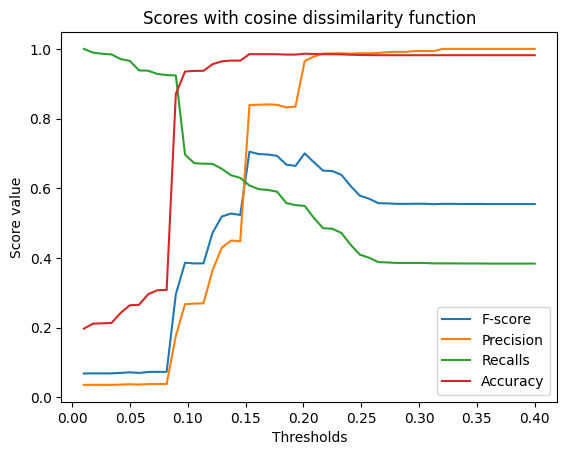

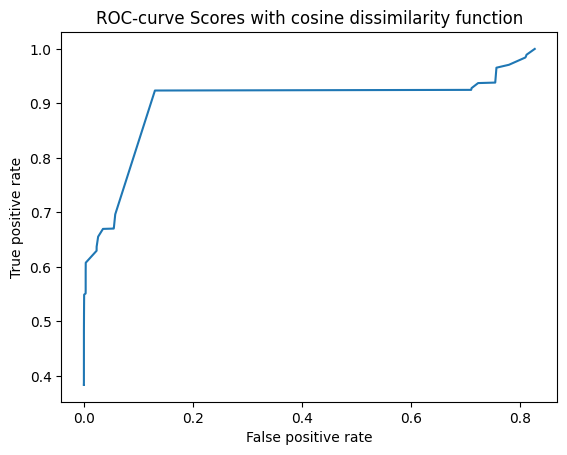

In [11]:
loaded_model = load_model("../Models/autoencoder_model_unsupervised_non_sequential2.keras")
thresholds = np.linspace(start = 0.01, stop = 0.4, num = 50, endpoint = True)
create_f_score_recall_precision_plots(loaded_model, x_test, y_test, difference_calculating_function_cosine_dissimilarity, thresholds, 'Scores with cosine dissimilarity function')

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 986us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 968us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 989us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 996us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 996us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 997us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1m

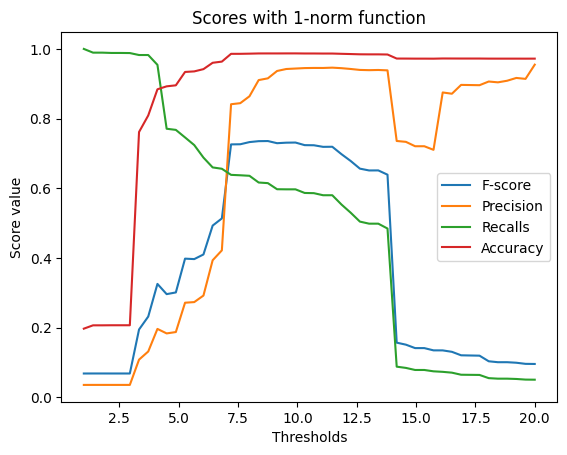

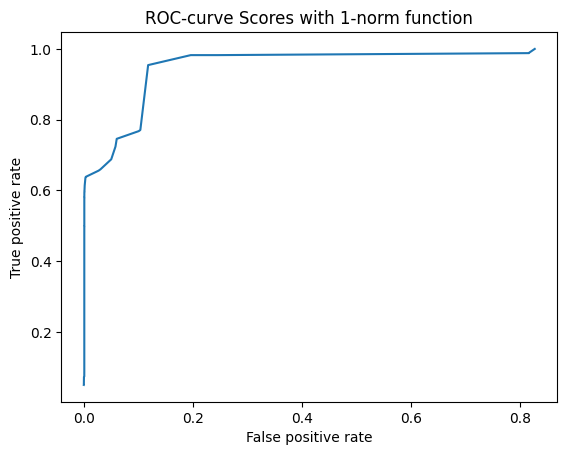

In [12]:
loaded_model = load_model("../Models/autoencoder_model_unsupervised_non_sequential2.keras")
thresholds = np.linspace(start = 1, stop = 20, num = 50, endpoint = True)
create_f_score_recall_precision_plots(loaded_model, x_test, y_test, difference_calculating_function_l_norm, thresholds, 'Scores with 1-norm function')

## Semisupervised autoencoder

In [13]:
x_train_success, y_train_success, x_test_success, y_test_success, x_train_fail, y_train_fail, x_test_fail, y_test_fail = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, True)
x_test = pd.concat([x_test_success, x_test_fail], ignore_index=True)
y_test = pd.concat([y_test_success, y_test_fail], ignore_index=True)
autoencoder_model, history = autoencoder_train(x_train_success,4,3)
autoencoder_model.save("../Models/autoencoder_model_semisupervised_non_sequential2.keras")


c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,100 (16.02 KB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2198 - val_loss: 0.2011
Epoch 2/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2166 - val_loss: 0.2011
Epoch 3/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2061 - val_loss: 0.2010
Epoch 4/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2259 - val_loss: 0.2010
Epoch 5/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2227 - val_loss: 0.2009
Epoch 6/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2186 - val_loss: 0.2009
Epoch 7/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1963 - val_loss: 0.2012
Epoch 8/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2040 - val_loss: 0.2010
Epoch 9/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2103 - val_loss: 0.2012
Epoch 10/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2157 - val_loss: 0.2009
Epoch 11/100
2792/2792 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1965 - val_loss: 0.2008
Epoch 12/100
2792/2

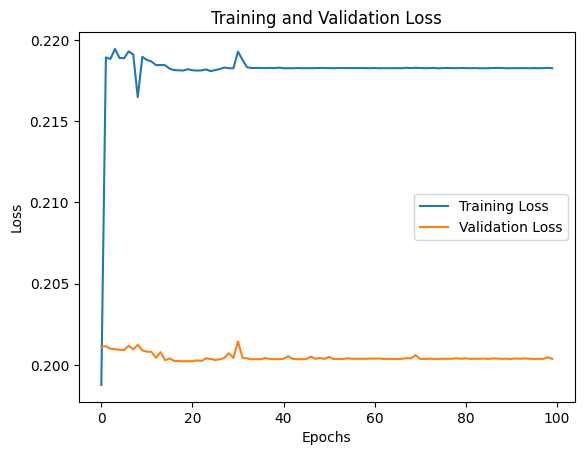

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
  22/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
  49/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
  38/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  47/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  61/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 976us/step
  47/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
  23/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  97/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step 

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  82/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step 

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  50/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  57/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 984us/step
  40/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  56/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 999us/step
  56/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  30/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  42/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  39/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  58/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  44/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:14: RuntimeWarning: invalid value encountered in scalar divide
  f_score = 2*precision*recall / (precision+recall)


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  45/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = (cm[1,1]) / (cm[1,1] + cm[0,1])


3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


C:\Users\mathb\AppData\Local\Temp\ipykernel_23868\1318325247.py:12: RuntimeWarning: invalid value encountered in scalar divide
  precision = (cm[1,1]) / (cm[1,1] + cm[0,1])


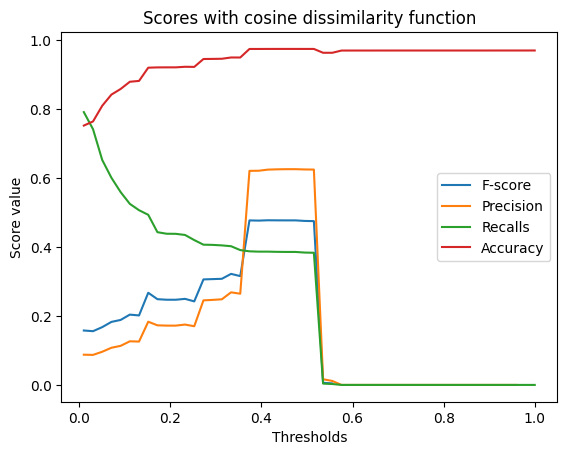

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 997us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 975us/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3595/35

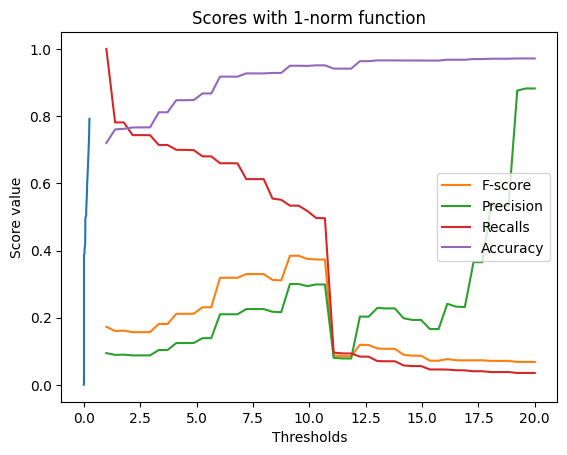

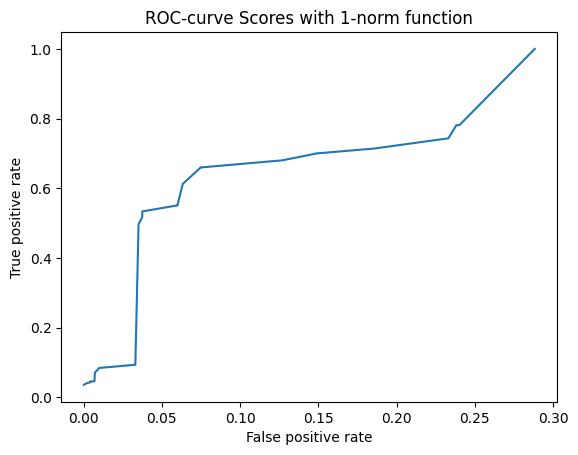

In [14]:
plot_history(history)
thresholds = np.linspace(start = 0.01, stop = 1, num = 50, endpoint = True)
create_f_score_recall_precision_plots(autoencoder_model, x_test, y_test, difference_calculating_function_cosine_dissimilarity, thresholds, 'Scores with cosine dissimilarity function')
thresholds = np.linspace(start = 1, stop = 20, num = 50, endpoint = True)
create_f_score_recall_precision_plots(autoencoder_model, x_test, y_test, difference_calculating_function_l_norm, thresholds, 'Scores with 1-norm function')

3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 975us/step


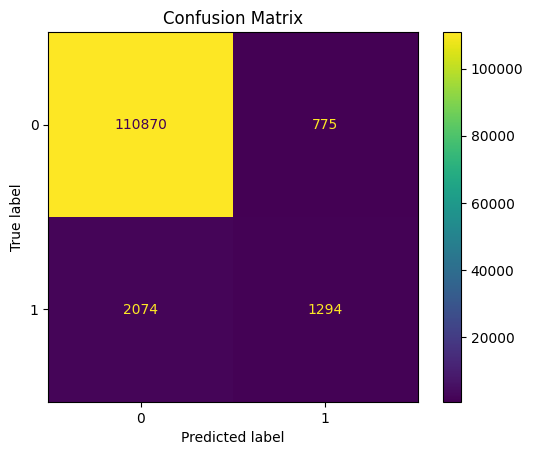

[[110870    775]
 [  2074   1294]]


(np.float64(0.625422909618173),
 np.float64(0.3842042755344418),
 np.float64(0.47599779290049665),
 np.float64(0.9752288871692765),
 np.float64(0.3842042755344418),
 np.float64(0.006941645393882395))

In [15]:
autoencoder_evaluate(autoencoder_model, x_test, y_test, difference_calculating_function_cosine_dissimilarity,0.5 , True)